In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/Colab Notebooks/Garbage"
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')
test_path = os.path.join(data_dir, 'test')
img_size = (384, 384)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path, image_size=img_size, batch_size=batch_size, label_mode='categorical')
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path, image_size=img_size, batch_size=batch_size, label_mode='categorical')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path, image_size=img_size, batch_size=batch_size, label_mode='categorical', shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)

# Define a sequential augmentation pipeline using tf.keras.Sequential
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Loads the input preprocessing function required by EfficientNet
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# map() function applies transformations/ augmentation to each (image, label) pair:
# First map: applies data_augmentation to the image.
# Second map: applies preprocess_input.
# .prefetch(AUTOTUNE): overlaps data preprocessing with model execution to speed up training.

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)) \
                   .map(lambda x, y: (preprocess_input(x), y)) \
                   .prefetch(AUTOTUNE)

# Applied preprocessing - without augmentation- on val and test splits
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)


'''prefetch() is a method used in the TensorFlow tf.data pipeline that allows the system to prepare the next batch of data while the current one is being used by the model.

Without prefetch:
Model processes batch 1.Then waits for batch 2 to load.Then processes batch 2.Waits again for batch 3...
With prefetch:
While the model is training on batch 1,It loads batch 2 in parallel.So there's no waiting time between batches.

prefetch(AUTOTUNE) — AUTOTUNE lets TensorFlow automatically pick the best prefetch buffer size based on your system (CPU/GPU, memory, etc.).
This reduces bottlenecks between data loading and GPU training.

| Time Step | Data Loading | Model Training |
| --------- | ------------ | -------------- |
| t1        | Batch 1      |                |
| t2        | Batch 2      | Batch 1        |
| t3        | Batch 3      | Batch 2        |
| t4        | Batch 4      | Batch 3        |
| ...       | ...          | ...            |
'''

base_model = EfficientNetB0(include_top=False, input_shape=img_size + (3,), weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Reduce spatial dimensions
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

Found 1766 files belonging to 6 classes.
Found 377 files belonging to 6 classes.
Found 384 files belonging to 6 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)
base_model.trainable = True

#Fine-Tuning (Unfreeze Some EfficientNet Layers)
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5344 - loss: 1.2305 - val_accuracy: 0.8515 - val_loss: 0.4386 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7896 - loss: 0.5694 - val_accuracy: 0.8780 - val_loss: 0.3943 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7997 - loss: 0.5258 - val_accuracy: 0.8886 - val_loss: 0.3276 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8455 - loss: 0.4582 - val_accuracy: 0.8912 - val_loss: 0.3081 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8551 - loss: 0.3975 - val_accuracy: 0.9098 - val_loss: 0.3063 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8757 - loss: 0.3574 - val_accuracy: 0.9045 - val_loss: 0.2891 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8760 - loss: 0.3430 - val_acc

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
epochs_range = range(len(acc))
test_loss, test_acc = model.evaluate(test_ds)
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("/n Test Accuracy : ",test_acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9276 - loss: 0.2244
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


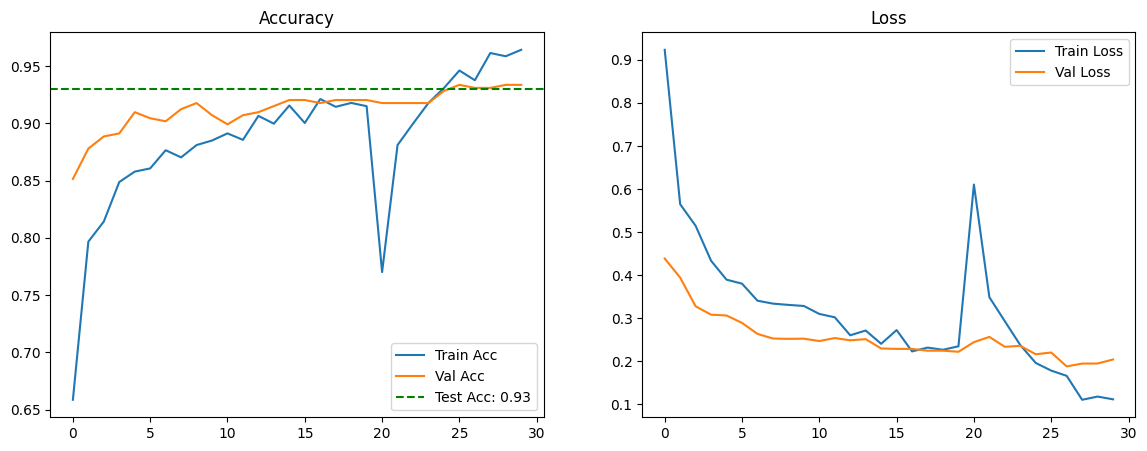

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.axhline(y=test_acc, linestyle='--', color='green', label=f'Test Acc: {test_acc:.2f}')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

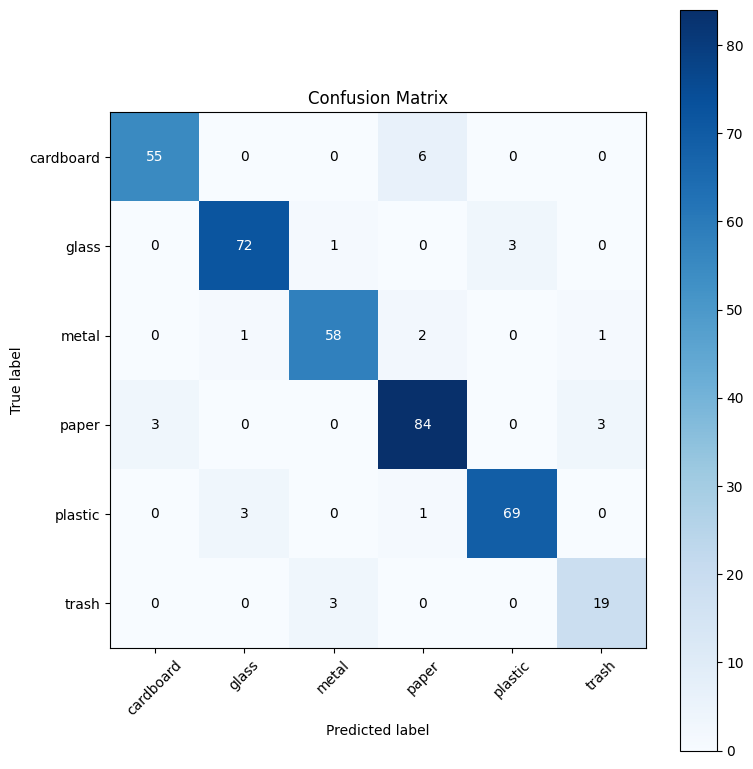


Classification Report:
               precision    recall  f1-score   support

   cardboard       0.95      0.90      0.92        61
       glass       0.95      0.95      0.95        76
       metal       0.94      0.94      0.94        62
       paper       0.90      0.93      0.92        90
     plastic       0.96      0.95      0.95        73
       trash       0.83      0.86      0.84        22

    accuracy                           0.93       384
   macro avg       0.92      0.92      0.92       384
weighted avg       0.93      0.93      0.93       384



In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
print('\nClassification Report:\n', classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
#model.save("wasteClassification.keras")
#loaded_model = tf.keras.models.load_model("wasteClassification.keras")

c:\Users\S1NdBAD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 129 variables whereas the saved optimizer has 256 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Randomly selected image: d:\Coding\VS Code\Python\Image Processing\Garbage\test\cardboard\cardboard11.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Model prediction: cardboard


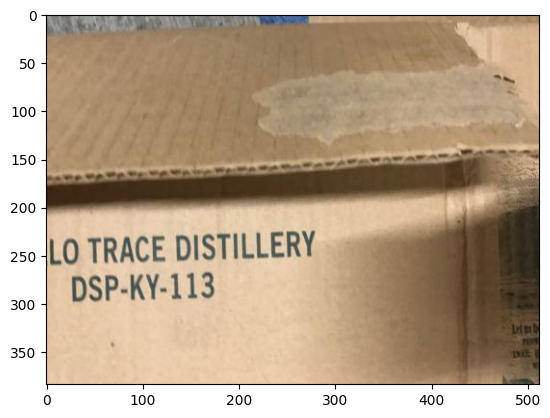

In [ ]:
import random
import cv2
from IPython.display import Image as IPImage, display
%matplotlib inline
all_image_paths = []
for split in [
    #'train', 'val',
    'test']:
    split_dir = os.path.join(data_dir, split)
    for class_dir in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_dir)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_image_paths.append(os.path.join(class_path, fname))

random_image_path = random.choice(all_image_paths)
print(f"Randomly selected image: {random_image_path}")

img = cv2.imread(random_image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, img_size)
img_array = np.expand_dims(img_resized, axis=0)
img_array = preprocess_input(img_array)

pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]

print(f"Model prediction: {pred_class}")